In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/email-phishing-dataset/email_phishing_data.csv


In [2]:
#load data
df = pd.read_csv("/kaggle/input/email-phishing-dataset/email_phishing_data.csv")
df.head(5)

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


In [3]:
df.duplicated().sum()

319794

In [4]:
df.columns

Index(['num_words', 'num_unique_words', 'num_stopwords', 'num_links',
       'num_unique_domains', 'num_email_addresses', 'num_spelling_errors',
       'num_urgent_keywords', 'label'],
      dtype='object')

Data Aggregation
Group data by category to reduce the size of the dataset.
Example: Group sales by month instead of by day.

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.DataFrame(df)


In [6]:
#Standarization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Creating a DataFrame for the Principal Components
data_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Load Components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_data = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=data.columns)

# Load Display
print("Charges des composantes principales :")
print(loadings_data)

Charges des composantes principales :
                          PC1       PC2
num_words            0.931102  0.321395
num_unique_words     0.758100 -0.292885
num_stopwords        0.914212  0.338314
num_links            0.299549 -0.758227
num_unique_domains   0.304873 -0.765572
num_email_addresses  0.127984 -0.175760
num_spelling_errors  0.871380  0.292931
num_urgent_keywords  0.340604 -0.466045
label               -0.000192  0.002083


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


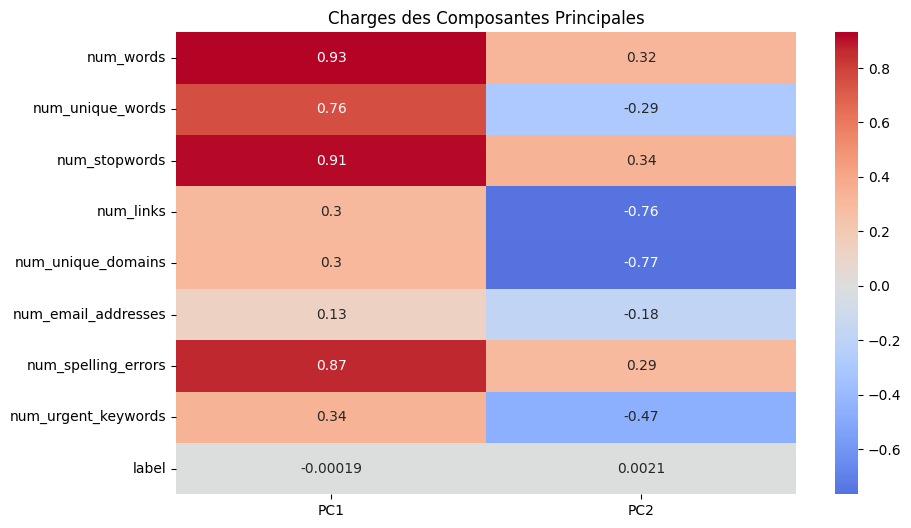

In [7]:
# Visualization of loads
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_data, annot=True, cmap='coolwarm', center=0)
plt.title('Charges des Composantes Principales')
plt.show()

The variables num_words, num_stopwords, and num_spelling_errors have high loadings on PC1  they strongly influence this component.

num_links and num_unique_domains have significant negative loadings on PC2  they could indicate behavior typical of phishing emails.

label has a very low loading on both components  the principal components do not directly capture the label, but this is expected, since the PCA is unsupervised.

In [8]:

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Selection of relevant features
features = [
    'num_words',
    'num_unique_words',
    'num_stopwords',
    'num_links',
    'num_unique_domains',
    'num_email_addresses',
    'num_spelling_errors',
    'num_urgent_keywords'
]

X = df[features]
y = df['label']

# Data Standarization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division into training and test game
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


2025-04-18 23:52:06.180495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745020326.444575      14 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745020326.521928      14 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Model definition
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # 8 characteristic
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # binary output
])

# Model Compilation
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


2025-04-18 23:52:21.913346: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9840 - loss: 0.0887 - val_accuracy: 0.9869 - val_loss: 0.0662
Epoch 2/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9869 - loss: 0.0668 - val_accuracy: 0.9869 - val_loss: 0.0652
Epoch 3/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9866 - loss: 0.0672 - val_accuracy: 0.9869 - val_loss: 0.0663
Epoch 4/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9868 - loss: 0.0645 - val_accuracy: 0.9869 - val_loss: 0.0625
Epoch 5/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9867 - loss: 0.0643 - val_accuracy: 0.9869 - val_loss: 0.0628
Epoch 6/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9869 - loss: 0.0632 - val_accuracy: 0.9870 - val_loss: 0.0622
Epoch 7/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9871 - loss: 0.0622 - val_accuracy: 0.9870 - val_loss: 0.0616
Epoch 8/20
10497/10497 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on the test set : {accuracy:.2f}")


3281/3281 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9872 - loss: 0.0597
Accuracy on the test set : 0.99
